<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/HippoWithResNetU_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Setup and Imports
# Purpose: Import libraries, mount Google Drive, set random seed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import zipfile
from google.colab import drive
drive.mount('/content/drive')
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
print(f"TensorFlow version: {tf.__version__}")
print("Environment setup complete.")

Mounted at /content/drive
TensorFlow version: 2.18.0
Environment setup complete.


In [2]:
# Cell 2: Define Metrics
# Purpose: Define metrics for segmentation.
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    sum_masks = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)
    return (2. * intersection + smooth) / (sum_masks + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def compute_metrics(y_true, y_pred, threshold=0.5):
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    dice = dice_coef(y_true, y_pred_bin)
    iou_score = iou(y_true, y_pred_bin)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred_bin, [-1])
    precision = tf.reduce_sum(y_true_f * y_pred_f) / (tf.reduce_sum(y_pred_f) + 1e-6)
    recall = tf.reduce_sum(y_true_f * y_pred_f) / (tf.reduce_sum(y_true_f) + 1e-6)
    return dice.numpy(), iou_score.numpy(), precision.numpy(), recall.numpy()

print("Metrics defined: Dice, IoU, Precision, Recall")

Metrics defined: Dice, IoU, Precision, Recall


Found 499 image files, 499 left mask files, 499 right mask files
Sample images: ['/content/hippocampus_dataset/aug/images/img_aug1.jpg', '/content/hippocampus_dataset/aug/images/img_aug10.jpg', '/content/hippocampus_dataset/aug/images/img_aug100.jpg']
Sample left masks: ['/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug10.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug100.jpg']
Sample right masks: ['/content/hippocampus_dataset/aug/masks/right/maskright_aug1.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug10.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug100.jpg']
Visualizing sample raw masks...


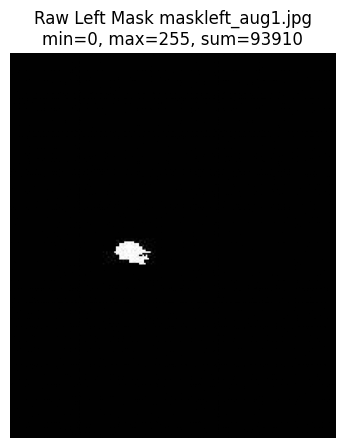

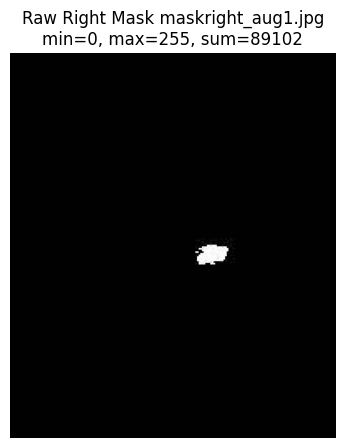

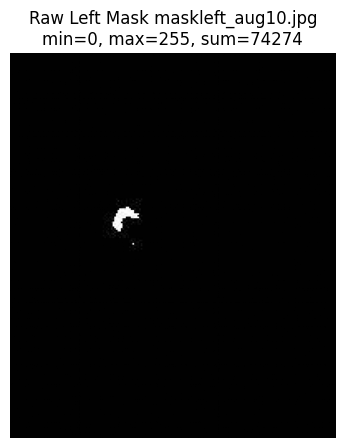

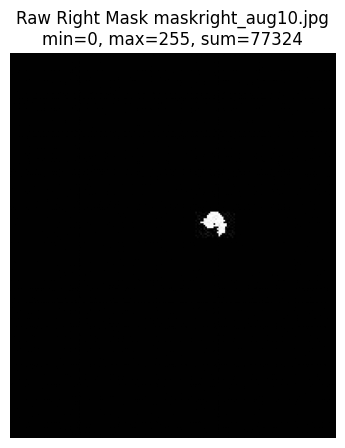

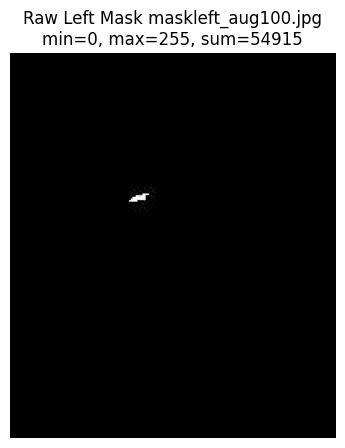

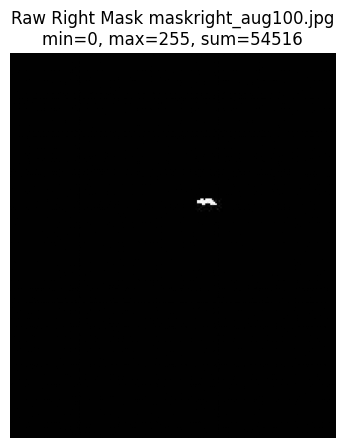

Paired 499 image-mask pairs
Raw left mask maskleft_aug1.jpg: min=0, max=255, sum=93910
Raw right mask maskright_aug1.jpg: min=0, max=255, sum=89102
Combined mask: 16384.0 positive pixels
Raw left mask maskleft_aug10.jpg: min=0, max=255, sum=74274
Raw right mask maskright_aug10.jpg: min=0, max=255, sum=77324
Combined mask: 16384.0 positive pixels
Raw left mask maskleft_aug100.jpg: min=0, max=255, sum=54915
Raw right mask maskright_aug100.jpg: min=0, max=255, sum=54516
Combined mask: 16384.0 positive pixels
Raw left mask maskleft_aug101.jpg: min=0, max=255, sum=104054
Raw right mask maskright_aug101.jpg: min=0, max=255, sum=97460
Combined mask: 16384.0 positive pixels
Raw left mask maskleft_aug102.jpg: min=0, max=255, sum=66027
Raw right mask maskright_aug102.jpg: min=0, max=255, sum=65761
Combined mask: 16384.0 positive pixels
Raw left mask maskleft_aug103.jpg: min=0, max=255, sum=118364
Raw right mask maskright_aug103.jpg: min=0, max=255, sum=121672
Combined mask: 16384.0 positive pixe

In [8]:
# Cell 3: Data Loading
# Purpose: Load MRI images and masks, combine left/right, debug empty masks.
def load_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def load_mask(mask_left_path, mask_right_path, target_size=(128, 128)):
    mask = np.zeros(target_size, dtype=np.float32)
    pixel_counts = []

    for path, side in [(mask_left_path, 'left'), (mask_right_path, 'right')]:
        if path:
            raw_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if raw_mask is None:
                print(f"Warning: Failed to load {side} mask: {path}")
                continue
            print(f"Raw {side} mask {os.path.basename(path)}: min={raw_mask.min()}, max={raw_mask.max()}, sum={raw_mask.sum()}")
            resized_mask = cv2.resize(raw_mask, target_size, interpolation=cv2.INTER_NEAREST)
            # Try multiple thresholding approaches
            binary_mask = (resized_mask > 0).astype(np.float32)
            if binary_mask.sum() == 0 and resized_mask.max() > 0:
                print(f"Retrying threshold for {side} mask: mean={resized_mask.mean()}")
                binary_mask = (resized_mask > resized_mask.mean()).astype(np.float32)
            pixel_counts.append(np.sum(binary_mask))
            mask = np.maximum(mask, binary_mask)

    if mask.sum() == 0:
        print(f"Warning: Combined mask for {os.path.basename(mask_left_path or mask_right_path)} is empty")
    print(f"Combined mask: {mask.sum()} positive pixels")
    return mask[:, :, np.newaxis].astype(np.float32)

# Visualize sample raw masks
def visualize_raw_mask(path, title):
    if not path:
        return
    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if raw is None:
        print(f"Cannot visualize {title}: Failed to load")
        return
    plt.figure(figsize=(5, 5))
    plt.imshow(raw, cmap='gray')
    plt.title(f"{title}\nmin={raw.min()}, max={raw.max()}, sum={raw.sum()}")
    plt.axis('off')
    plt.show()

# Unzip dataset
zip_path = '/content/hippocampus segmentation dataset.zip'
extract_path = '/content/hippocampus_dataset'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find files
def find_files(directory, extensions):
    files = []
    for root, _, filenames in os.walk(directory):
        for f in filenames:
            if any(f.lower().endswith(ext) for ext in extensions):
                files.append(os.path.join(root, f))
    return sorted(files)

image_extensions = ('.jpg', '.jpeg', '.png')
mask_extensions = ('.jpg', '.jpeg', '.png')
image_files = find_files(os.path.join(extract_path, 'aug/images'), image_extensions)
mask_left_files = find_files(os.path.join(extract_path, 'aug/masks/left'), mask_extensions)
mask_right_files = find_files(os.path.join(extract_path, 'aug/masks/right'), mask_extensions)

print(f"Found {len(image_files)} image files, {len(mask_left_files)} left mask files, {len(mask_right_files)} right mask files")
if image_files:
    print("Sample images:", image_files[:3])
if mask_left_files:
    print("Sample left masks:", mask_left_files[:3])
if mask_right_files:
    print("Sample right masks:", mask_right_files[:3])

# Visualize first few raw masks
print("Visualizing sample raw masks...")
for i in range(min(3, len(mask_left_files), len(mask_right_files))):
    visualize_raw_mask(mask_left_files[i], f"Raw Left Mask {os.path.basename(mask_left_files[i])}")
    visualize_raw_mask(mask_right_files[i], f"Raw Right Mask {os.path.basename(mask_right_files[i])}")

# Pair images with masks
train_data = []
for img in image_files:
    img_name = os.path.basename(img).lower().split('.')[0]
    left_mask = next((m for m in mask_left_files if img_name.replace('img', 'maskleft') in m.lower()), None)
    right_mask = next((m for m in mask_right_files if img_name.replace('img', 'maskright') in m.lower()), None)
    if left_mask or right_mask:
        train_data.append((img, left_mask, right_mask))
    else:
        print(f"Warning: No masks found for image: {img}")

print(f"Paired {len(train_data)} image-mask pairs")
if not train_data:
    raise ValueError("No image-mask pairs found.")

# Load data
X = []
Y = []
for img_path, left_path, right_path in train_data:
    try:
        img = load_image(img_path)
        mask = load_mask(left_path, right_path)
        X.append(img)
        Y.append(mask)
    except Exception as e:
        print(f"Error loading {img_path}: {str(e)}")

X = np.array(X)
Y = np.array(Y)
if X.shape[0] == 0:
    raise ValueError("No data loaded.")

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")
print(f"Sample mask positive pixels: {np.sum(Y_train[:5], axis=(1,2,3)).tolist()}")

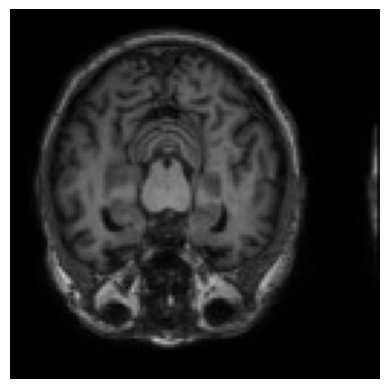

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train
plt.imshow(X_train[0] / 255.0 if X_train[0].max() > 1 else X_train[0])
plt.axis('off')
plt.show()

(197, 233, 3) 0 198


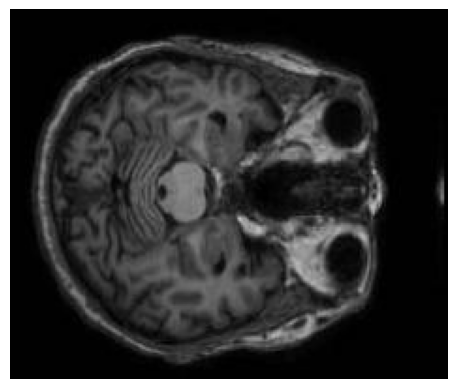

In [15]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/content/hippocampus_dataset/aug/images/img_aug1.jpg')
print(img.shape, img.min(), img.max())
plt.imshow(img)
plt.axis('off')
plt.show()

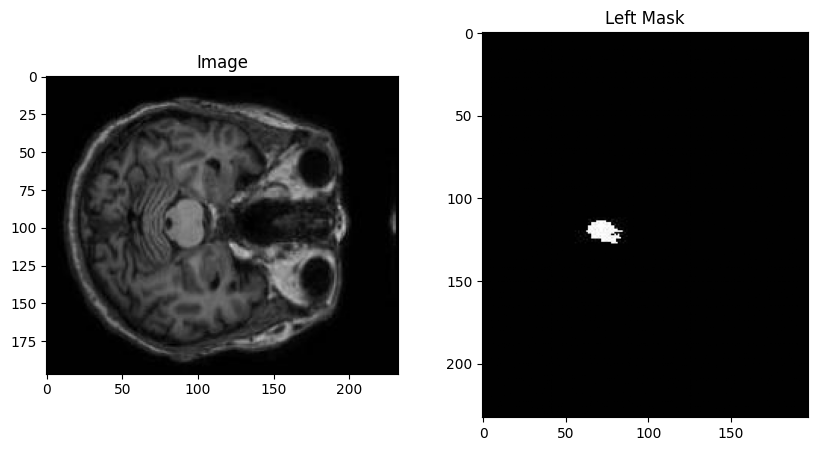

In [16]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/content/hippocampus_dataset/aug/images/img_aug1.jpg')
mask_left = cv2.imread('/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', 0)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(mask_left, cmap='gray')
plt.title('Left Mask')
plt.show()

In [17]:
# Cell 5: Define Montage Function
# Purpose: Create montages of images or masks.
def custom_montage(images, n_rows=5, n_cols=5, cmap='gray'):
    if len(images) == 0:
        return None
    images = images[:n_rows * n_cols]
    h, w = images.shape[1:3]
    if images.ndim == 4 and images.shape[-1] == 1:
        images = images[..., 0]
    montage = np.zeros((h * n_rows, w * n_cols, images.shape[-1] if images.ndim > 3 else 1), dtype=np.float32)
    for i in range(min(len(images), n_rows * n_cols)):
        r, c = divmod(i, n_cols)
        img = images[i]
        montage[r*h:(r+1)*h, c*w:(c+1)*w] = img[..., np.newaxis] if img.ndim == 2 else img
    plt.figure(figsize=(n_cols*2, n_rows*2))
    plt.imshow(montage.squeeze(), cmap=cmap)
    plt.axis('off')
    return plt.gcf()

print("Montage function defined.")

Montage function defined.


In [18]:
# Cell 6: Define ResUNet Model
# Purpose: Define ResUNet for segmentation.
def res_block(x, filters):
    conv1 = layers.Conv2D(filters, 3, padding='same')(x)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(filters, 3, padding='same')(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    shortcut = layers.Conv2D(filters, 1, padding='same')(x)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([conv2, shortcut])
    return layers.Activation('relu')(x)

def build_resunet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    x1 = res_block(inputs, 64)
    x = layers.MaxPooling2D()(x1)
    x2 = res_block(x, 128)
    x = layers.MaxPooling2D()(x2)
    x = res_block(x, 256)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, x2])
    x = res_block(x, 128)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, x1])
    x = res_block(x, 64)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    return keras.models.Model(inputs, outputs)

resunet_model = build_resunet()
resunet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou]
)
resunet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 1,994,049 (7.61 MB)

 Trainable params: 1,990,209 (7.59 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [19]:
# Cell 7: Define Standard U-Net Model
# Purpose: Define U-Net for segmentation.
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    c1 = layers.Conv2D(64, 3, padding='same', activation='relu')(c1)
    p1 = layers.MaxPooling2D()(c1)
    c2 = layers.Conv2D(128, 3, padding='same', activation='relu')(p1)
    c2 = layers.Conv2D(128, 3, padding='same', activation='relu')(c2)
    p2 = layers.MaxPooling2D()(c2)
    c3 = layers.Conv2D(256, 3, padding='same', activation='relu')(p2)
    c3 = layers.Conv2D(256, 3, padding='same', activation='relu')(c3)
    u4 = layers.UpSampling2D()(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(128, 3, padding='same', activation='relu')(u4)
    c4 = layers.Conv2D(128, 3, padding='same', activation='relu')(c4)
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(64, 3, padding='same', activation='relu')(u5)
    c5 = layers.Conv2D(64, 3, padding='same', activation='relu')(c5)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    return keras.models.Model(inputs, outputs)

unet_model = build_unet()
unet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[dice_coef, iou]
)
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_16[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_18[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_20[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ conv2d_21[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 384)              │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    442,496 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_22[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 128, 128,  │          0 │ conv2d_23[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_24[0][0] 

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Cell 8: Training
# Purpose: Train ResUNet and U-Net with weighted loss.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def weighted_bce(y_true, y_pred):
    weights = tf.where(y_true > 0, 10.0, 1.0)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(bce * weights)

data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

batch_size = 8
drive_model_path = '/content/drive/MyDrive/Hippocampus_Models'
os.makedirs(drive_model_path, exist_ok=True)

resunet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'ResUNet.h5'),
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_dice_coef', mode='max')
]
if X_train.shape[0] > 0:
    print("Training ResUNet...")
    resunet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce,
        metrics=[dice_coef, iou]
    )
    resunet_results = resunet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=resunet_callbacks,
        verbose=1
    )

unet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'U-Net.h5'),
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_dice_coef', mode='max')
]
if X_train.shape[0] > 0:
    print("Training U-Net...")
    unet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce,
        metrics=[dice_coef, iou]
    )
    unet_results = unet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=unet_callbacks,
        verbose=1
    )

print("Training complete. Models saved to Google Drive.")

Training ResUNet...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/weighted_bce/mul defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [8,128,128] vs. [8,128,128,1]
	 [[{{node compile_loss/weighted_bce/mul}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_12972[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_13426]

In [21]:
# Cell 3: Data Loading
# Purpose: Load and preprocess MRI images and masks, combining left/right, debugging empty masks.
def load_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def load_mask(mask_left_path, mask_right_path, target_size=(128, 128)):
    mask = np.zeros(target_size, dtype=np.float32)
    pixel_counts = []

    for path, side in [(mask_left_path, 'left'), (mask_right_path, 'right')]:
        if path:
            raw_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if raw_mask is None:
                print(f"Warning: Failed to load {side} mask: {path}")
                continue
            print(f"Raw {side} mask {os.path.basename(path)}: shape={raw_mask.shape}, min={raw_mask.min()}, max={raw_mask.max()}, sum={raw_mask.sum()}, unique={np.unique(raw_mask)}")
            resized_mask = cv2.resize(raw_mask, target_size)
            # Try multiple thresholds to find non-empty mask
            for thresh in [0, 1, 127]:
                binary_mask = (resized_mask > thresh).astype(np.float32)
                pixel_sum = np.sum(binary_mask)
                print(f"Threshold >{thresh}: {pixel_sum} positive pixels")
                if pixel_sum > 0:
                    mask = np.maximum(mask, binary_mask)
                    break
            pixel_counts.append(pixel_sum)

    pixel_sum = np.sum(mask)
    print(f"Combined mask for {os.path.basename(mask_left_path or mask_right_path)}: {pixel_sum} positive pixels")
    if pixel_sum == 0:
        print(f"Warning: Combined mask is empty. Check raw mask content above.")
    return mask[:, :, np.newaxis].astype(np.float32)

# Unzip dataset
zip_path = '/content/hippocampus segmentation dataset.zip'
extract_path = '/content/hippocampus_dataset'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find files
def find_files(directory, extensions):
    files = []
    for root, _, filenames in os.walk(directory):
        for f in filenames:
            if any(f.lower().endswith(ext) for ext in extensions):
                files.append(os.path.join(root, f))
    return sorted(files)

image_extensions = ('.jpg', '.jpeg', '.png')
mask_extensions = ('.jpg', '.jpeg', '.png')
image_files = find_files(os.path.join(extract_path, 'aug/images'), image_extensions)
mask_left_files = find_files(os.path.join(extract_path, 'aug/masks/left'), mask_extensions)
mask_right_files = find_files(os.path.join(extract_path, 'aug/masks/right'), mask_extensions)

print(f"Found {len(image_files)} image files, {len(mask_left_files)} left mask files, {len(mask_right_files)} right mask files")
if image_files:
    print("Sample images:", image_files[:3])
if mask_left_files:
    print("Sample left masks:", mask_left_files[:3])
if mask_right_files:
    print("Sample right masks:", mask_right_files[:3])

# Pair images with masks
train_data = []
for img in image_files:
    img_name = os.path.basename(img).lower().split('.')[0]
    left_mask = next((m for m in mask_left_files if img_name.replace('img', 'maskleft') in m.lower()), None)
    right_mask = next((m for m in mask_right_files if img_name.replace('img', 'maskright') in m.lower()), None)
    if left_mask or right_mask:
        train_data.append((img, left_mask, right_mask))
    else:
        print(f"Warning: No masks found for image: {img}")

print(f"Paired {len(train_data)} image-mask pairs")
if not train_data:
    raise ValueError("No image-mask pairs found. Check file names or directory structure.")

# Load data
X = []
Y = []
for img_path, left_path, right_path in train_data:
    try:
        img = load_image(img_path)
        mask = load_mask(left_path, right_path)
        X.append(img)
        Y.append(mask)
    except Exception as e:
        print(f"Error loading {img_path}: {str(e)}")

X = np.array(X)
Y = np.array(Y)
if X.shape[0] == 0:
    raise ValueError("No data loaded.")

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")
print(f"Sample mask positive pixels: {np.sum(Y_train[:5], axis=(1,2,3)).tolist()}")

Found 499 image files, 499 left mask files, 499 right mask files
Sample images: ['/content/hippocampus_dataset/aug/images/img_aug1.jpg', '/content/hippocampus_dataset/aug/images/img_aug10.jpg', '/content/hippocampus_dataset/aug/images/img_aug100.jpg']
Sample left masks: ['/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug10.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug100.jpg']
Sample right masks: ['/content/hippocampus_dataset/aug/masks/right/maskright_aug1.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug10.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug100.jpg']
Paired 499 image-mask pairs
Raw left mask maskleft_aug1.jpg: shape=(233, 197), min=0, max=255, sum=93910, unique=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  27  40  41 223 224 227 228 230 232 233
 235 236 237 238 239 240 241 242 243 244 245 2

In [22]:
# Cell 8: Training
# Purpose: Train ResUNet and U-Net with weighted loss, fixed shape mismatch.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def weighted_bce(y_true, y_pred):
    weights = tf.where(y_true > 0, 10.0, 1.0)  # Shape: [batch, 128, 128, 1]
    # Compute BCE per sample, preserving shape
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    # Ensure bce has same shape as weights
    bce = tf.expand_dims(bce, axis=-1)  # Shape: [batch, 128, 128, 1]
    weighted_loss = bce * weights
    return tf.reduce_mean(weighted_loss)

data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

batch_size = 8
drive_model_path = '/content/drive/MyDrive/Hippocampus_Models'
os.makedirs(drive_model_path, exist_ok=True)

resunet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'ResUNet.h5'),
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_dice_coef', mode='max')
]
if X_train.shape[0] > 0:
    print("Training ResUNet...")
    resunet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce,
        metrics=[dice_coef, iou]
    )
    resunet_results = resunet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=resunet_callbacks,
        verbose=1
    )

unet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'U-Net.h5'),
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_dice_coef', mode='max')
]
if X_train.shape[0] > 0:
    print("Training U-Net...")
    unet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce,
        metrics=[dice_coef, iou]
    )
    unet_results = unet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=unet_callbacks,
        verbose=1
    )

print("Training complete. Models saved to Google Drive.")

Training ResUNet...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - dice_coef: 0.9582 - iou: 0.9221 - loss: 0.8828

57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 659ms/step - dice_coef: 0.9586 - iou: 0.9228 - loss: 0.8747 - val_dice_coef: 0.8554 - val_iou: 0.7473 - val_loss: 2.9195
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - dice_coef: 0.9950 - iou: 0.9900 - loss: 0.0999

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - dice_coef: 0.9950 - iou: 0.9901 - loss: 0.0998 - val_dice_coef: 0.9379 - val_iou: 0.8831 - val_loss: 1.2428
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - dice_coef: 0.9965 - iou: 0.9929 - loss: 0.0709

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - dice_coef: 0.9965 - iou: 0.9930 - loss: 0.0708 - val_dice_coef: 0.9687 - val_iou: 0.9392 - val_loss: 0.6271
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - dice_coef: 0.9971 - iou: 0.9943 - loss: 0.0571

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - dice_coef: 0.9971 - iou: 0.9943 - loss: 0.0570 - val_dice_coef: 0.9882 - val_iou: 0.9766 - val_loss: 0.2373
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - dice_coef: 0.9976 - iou: 0.9953 - loss: 0.0470

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - dice_coef: 0.9976 - iou: 0.9953 - loss: 0.0469 - val_dice_coef: 0.9943 - val_iou: 0.9887 - val_loss: 0.1143
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - dice_coef: 0.9980 - iou: 0.9960 - loss: 0.0404

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - dice_coef: 0.9980 - iou: 0.9960 - loss: 0.0404 - val_dice_coef: 0.9965 - val_iou: 0.9931 - val_loss: 0.0697
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.9982 - iou: 0.9964 - loss: 0.0362

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.9982 - iou: 0.9964 - loss: 0.0362 - val_dice_coef: 0.9974 - val_iou: 0.9949 - val_loss: 0.0516
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - dice_coef: 0.9984 - iou: 0.9968 - loss: 0.0319

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - dice_coef: 0.9984 - iou: 0.9968 - loss: 0.0319 - val_dice_coef: 0.9979 - val_iou: 0.9959 - val_loss: 0.0415
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.9986 - iou: 0.9972 - loss: 0.0284

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - dice_coef: 0.9986 - iou: 0.9972 - loss: 0.0284 - val_dice_coef: 0.9985 - val_iou: 0.9970 - val_loss: 0.0298
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9987 - iou: 0.9974 - loss: 0.0263

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9987 - iou: 0.9974 - loss: 0.0263 - val_dice_coef: 0.9987 - val_iou: 0.9973 - val_loss: 0.0267
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9988 - iou: 0.9976 - loss: 0.0233

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9988 - iou: 0.9976 - loss: 0.0232 - val_dice_coef: 0.9989 - val_iou: 0.9978 - val_loss: 0.0224
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9989 - iou: 0.9979 - loss: 0.0215

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9989 - iou: 0.9979 - loss: 0.0215 - val_dice_coef: 0.9989 - val_iou: 0.9979 - val_loss: 0.0212
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - dice_coef: 0.9990 - iou: 0.9980 - loss: 0.0198

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.9990 - iou: 0.9980 - loss: 0.0197 - val_dice_coef: 0.9990 - val_iou: 0.9981 - val_loss: 0.0195
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9991 - iou: 0.9981 - loss: 0.0182

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9991 - iou: 0.9981 - loss: 0.0182 - val_dice_coef: 0.9991 - val_iou: 0.9982 - val_loss: 0.0182
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9992 - iou: 0.9983 - loss: 0.0166

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9992 - iou: 0.9983 - loss: 0.0166 - val_dice_coef: 0.9992 - val_iou: 0.9984 - val_loss: 0.0162
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9992 - iou: 0.9984 - loss: 0.0158

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9992 - iou: 0.9984 - loss: 0.0158 - val_dice_coef: 0.9993 - val_iou: 0.9985 - val_loss: 0.0150
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9993 - iou: 0.9986 - loss: 0.0144

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9993 - iou: 0.9986 - loss: 0.0144 - val_dice_coef: 0.9993 - val_iou: 0.9986 - val_loss: 0.0139
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9993 - iou: 0.9987 - loss: 0.0133

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - dice_coef: 0.9993 - iou: 0.9987 - loss: 0.0133 - val_dice_coef: 0.9994 - val_iou: 0.9987 - val_loss: 0.0128
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9994 - iou: 0.9988 - loss: 0.0123

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - dice_coef: 0.9994 - iou: 0.9988 - loss: 0.0123 - val_dice_coef: 0.9994 - val_iou: 0.9988 - val_loss: 0.0119
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9994 - iou: 0.9988 - loss: 0.0117

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - dice_coef: 0.9994 - iou: 0.9988 - loss: 0.0117 - val_dice_coef: 0.9994 - val_iou: 0.9989 - val_loss: 0.0111
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9995 - iou: 0.9989 - loss: 0.0107

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - dice_coef: 0.9995 - iou: 0.9989 - loss: 0.0107 - val_dice_coef: 0.9995 - val_iou: 0.9990 - val_loss: 0.0100
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9995 - iou: 0.9990 - loss: 0.0101

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9995 - iou: 0.9990 - loss: 0.0101 - val_dice_coef: 0.9995 - val_iou: 0.9991 - val_loss: 0.0095
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9995 - iou: 0.9991 - loss: 0.0095

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9995 - iou: 0.9991 - loss: 0.0095 - val_dice_coef: 0.9996 - val_iou: 0.9991 - val_loss: 0.0089
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - dice_coef: 0.9996 - iou: 0.9991 - loss: 0.0089

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9996 - iou: 0.9991 - loss: 0.0089 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0084
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0083

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0083 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0081
Epoch 26/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0079

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0079 - val_dice_coef: 0.9996 - val_iou: 0.9992 - val_loss: 0.0078
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0075

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9996 - iou: 0.9992 - loss: 0.0075 - val_dice_coef: 0.9996 - val_iou: 0.9993 - val_loss: 0.0071
Epoch 28/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0070

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9996 - iou: 0.9993 - loss: 0.0070 - val_dice_coef: 0.9997 - val_iou: 0.9993 - val_loss: 0.0067
Epoch 29/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0066

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - dice_coef: 0.9997 - iou: 0.9993 - loss: 0.0066 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0062
Epoch 30/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0062

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0062 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0059
Epoch 31/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0062

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0062 - val_dice_coef: 0.9997 - val_iou: 0.9994 - val_loss: 0.0057
Epoch 32/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0056

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - dice_coef: 0.9997 - iou: 0.9994 - loss: 0.0056 - val_dice_coef: 0.9997 - val_iou: 0.9995 - val_loss: 0.0053
Epoch 33/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9997 - iou: 0.9995 - loss: 0.0053

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9997 - iou: 0.9995 - loss: 0.0053 - val_dice_coef: 0.9997 - val_iou: 0.9995 - val_loss: 0.0050
Epoch 34/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9997 - iou: 0.9995 - loss: 0.0050

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - dice_coef: 0.9997 - iou: 0.9995 - loss: 0.0050 - val_dice_coef: 0.9998 - val_iou: 0.9995 - val_loss: 0.0048
Epoch 35/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - dice_coef: 0.9998 - iou: 0.9995 - loss: 0.0047

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9998 - iou: 0.9995 - loss: 0.0047 - val_dice_coef: 0.9998 - val_iou: 0.9995 - val_loss: 0.0046
Epoch 36/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9998 - iou: 0.9995 - loss: 0.0046

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - dice_coef: 0.9998 - iou: 0.9995 - loss: 0.0046 - val_dice_coef: 0.9998 - val_iou: 0.9996 - val_loss: 0.0043
Epoch 37/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0043

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0043 - val_dice_coef: 0.9998 - val_iou: 0.9996 - val_loss: 0.0040
Epoch 38/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0041

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0041 - val_dice_coef: 0.9998 - val_iou: 0.9996 - val_loss: 0.0039
Epoch 39/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0038

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0038 - val_dice_coef: 0.9998 - val_iou: 0.9996 - val_loss: 0.0037
Epoch 40/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0036

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0036 - val_dice_coef: 0.9998 - val_iou: 0.9997 - val_loss: 0.0034
Epoch 41/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0036

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9998 - iou: 0.9996 - loss: 0.0036 - val_dice_coef: 0.9998 - val_iou: 0.9997 - val_loss: 0.0033
Epoch 42/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9998 - iou: 0.9997 - loss: 0.0034

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - dice_coef: 0.9998 - iou: 0.9997 - loss: 0.0034 - val_dice_coef: 0.9998 - val_iou: 0.9997 - val_loss: 0.0032
Epoch 43/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9998 - iou: 0.9997 - loss: 0.0033

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.9998 - iou: 0.9997 - loss: 0.0033 - val_dice_coef: 0.9998 - val_iou: 0.9997 - val_loss: 0.0030
Epoch 44/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9998 - iou: 0.9997 - loss: 0.0031

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - dice_coef: 0.9998 - iou: 0.9997 - loss: 0.0031 - val_dice_coef: 0.9999 - val_iou: 0.9997 - val_loss: 0.0029
Epoch 45/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0030

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0030 - val_dice_coef: 0.9999 - val_iou: 0.9997 - val_loss: 0.0028
Epoch 46/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0028

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0028 - val_dice_coef: 0.9999 - val_iou: 0.9997 - val_loss: 0.0027
Epoch 47/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0027

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0027 - val_dice_coef: 0.9999 - val_iou: 0.9998 - val_loss: 0.0025
Epoch 48/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0025

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - dice_coef: 0.9999 - iou: 0.9997 - loss: 0.0025 - val_dice_coef: 0.9999 - val_iou: 0.9998 - val_loss: 0.0024
Epoch 49/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.9999 - iou: 0.9998 - loss: 0.0024

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.9999 - iou: 0.9998 - loss: 0.0024 - val_dice_coef: 0.9999 - val_iou: 0.9998 - val_loss: 0.0022
Epoch 50/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.9999 - iou: 0.9998 - loss: 0.0024

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.9999 - iou: 0.9998 - loss: 0.0024 - val_dice_coef: 0.9999 - val_iou: 0.9998 - val_loss: 0.0022
Training U-Net...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - dice_coef: 0.7876 - iou: 0.6736 - loss: 4.3764

57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 361ms/step - dice_coef: 0.7896 - iou: 0.6766 - loss: 4.3350 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 9.8810e-06
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 7.2808e-06

57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 7.2545e-06 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 3.9292e-06
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 4.4070e-06 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 3.2757e-06
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 3.3529e-06

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 3.3528e-06 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 2.4783e-06
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 2.6753e-06 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 1.7124e-06
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 1.9200e-06

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 1.9172e-06 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 1.1396e-06
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 1.2946e-06 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 7.6135e-07
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 9.3691e-07 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 5.3644e-07
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 6.9634e-07 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 3.8719e-07
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 4.6475e-07 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 2.9280e-07
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - dice_coef: 1.0000 - iou: 1.0000 - loss: 3.7618e-07 - val_dice_coef: 1.0000 - val_iou: 1.0000 - val_loss: 2.2509

In [23]:
# Cell 3: Data Loading
# Purpose: Load MRI images and masks, combine left/right, debug empty masks.
import os
import numpy as np
import cv2
import zipfile
from sklearn.model_selection import train_test_split

def load_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def load_mask(mask_left_path, mask_right_path, target_size=(128, 128)):
    mask = np.zeros(target_size, dtype=np.float32)
    debug_info = []

    for path, side in [(mask_left_path, 'left'), (mask_right_path, 'right')]:
        if not path:
            debug_info.append(f"No {side} mask provided")
            continue
        if not os.path.exists(path):
            debug_info.append(f"{side} mask not found: {path}")
            continue
        raw_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if raw_mask is None:
            debug_info.append(f"Failed to load {side} mask: {path}")
            continue
        # Debug raw mask
        debug_info.append(
            f"Raw {side} mask {os.path.basename(path)}: "
            f"shape={raw_mask.shape}, min={raw_mask.min()}, max={raw_mask.max()}, "
            f"sum={raw_mask.sum()}, unique={np.unique(raw_mask)[:10]}"
        )
        # Try multiple preprocessing approaches
        resized_mask = cv2.resize(raw_mask, target_size)
        # 1. Direct threshold
        binary_mask = (resized_mask > 0).astype(np.float32)
        pixel_sum = np.sum(binary_mask)
        debug_info.append(f"Threshold >0: {pixel_sum} positive pixels")
        if pixel_sum > 0:
            mask = np.maximum(mask, binary_mask)
        else:
            # 2. Normalize and threshold
            norm_mask = resized_mask / (raw_mask.max() + 1e-6)
            binary_mask = (norm_mask > 0.1).astype(np.float32)
            pixel_sum = np.sum(binary_mask)
            debug_info.append(f"Normalized >0.1: {pixel_sum} positive pixels")
            if pixel_sum > 0:
                mask = np.maximum(mask, binary_mask)

    pixel_sum = np.sum(mask)
    debug_info.append(f"Combined mask: {pixel_sum} positive pixels")
    if pixel_sum == 0:
        debug_info.append(f"Warning: Combined mask is empty for {os.path.basename(mask_left_path or mask_right_path)}")
    print("\n".join(debug_info))
    return mask[:, :, np.newaxis].astype(np.float32)

# Unzip dataset
zip_path = '/content/hippocampus segmentation dataset.zip'
extract_path = '/content/hippocampus_dataset'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find files
def find_files(directory, extensions):
    files = []
    for root, _, filenames in os.walk(directory):
        for f in filenames:
            if any(f.lower().endswith(ext) for ext in extensions):
                files.append(os.path.join(root, f))
    return sorted(files)

image_extensions = ('.jpg', '.jpeg', '.png')
mask_extensions = ('.jpg', '.jpeg', '.png')
image_files = find_files(os.path.join(extract_path, 'aug/images'), image_extensions)
mask_left_files = find_files(os.path.join(extract_path, 'aug/masks/left'), mask_extensions)
mask_right_files = find_files(os.path.join(extract_path, 'aug/masks/right'), mask_extensions)

print(f"Found {len(image_files)} image files, {len(mask_left_files)} left mask files, {len(mask_right_files)} right mask files")
if image_files:
    print("Sample images:", image_files[:3])
if mask_left_files:
    print("Sample left masks:", mask_left_files[:3])
if mask_right_files:
    print("Sample right masks:", mask_right_files[:3])

# Pair images with masks
train_data = []
for img in image_files:
    img_name = os.path.basename(img).lower().split('.')[0]
    left_mask = next((m for m in mask_left_files if img_name.replace('img', 'maskleft') in m.lower()), None)
    right_mask = next((m for m in mask_right_files if img_name.replace('img', 'maskright') in m.lower()), None)
    if left_mask or right_mask:
        train_data.append((img, left_mask, right_mask))
    else:
        print(f"Warning: No masks found for image: {img}")

print(f"Paired {len(train_data)} image-mask pairs")
if not train_data:
    raise ValueError("No image-mask pairs found. Check file names or directory structure.")

# Load data
X = []
Y = []
for img_path, left_path, right_path in train_data[:10]:  # Limit to 10 for debugging
    try:
        img = load_image(img_path)
        mask = load_mask(left_path, right_path)
        X.append(img)
        Y.append(mask)
    except Exception as e:
        print(f"Error loading {img_path}: {str(e)}")

X = np.array(X)
Y = np.array(Y)
if X.shape[0] == 0:
    raise ValueError("No data loaded.")

# Split data
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")
print(f"Sample mask positive pixels: {np.sum(Y_train[:5], axis=(1,2,3)).tolist()}")

Found 499 image files, 499 left mask files, 499 right mask files
Sample images: ['/content/hippocampus_dataset/aug/images/img_aug1.jpg', '/content/hippocampus_dataset/aug/images/img_aug10.jpg', '/content/hippocampus_dataset/aug/images/img_aug100.jpg']
Sample left masks: ['/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug10.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug100.jpg']
Sample right masks: ['/content/hippocampus_dataset/aug/masks/right/maskright_aug1.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug10.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug100.jpg']
Paired 499 image-mask pairs
Raw left mask maskleft_aug1.jpg: shape=(233, 197), min=0, max=255, sum=93910, unique=[0 1 2 3 4 5 6 7 8 9]
Threshold >0: 16380.0 positive pixels
Raw right mask maskright_aug1.jpg: shape=(233, 197), min=0, max=255, sum=89102, unique=[0 1 2 3 4 5 6 7 8 9]
Threshold >0: 16383.0 p

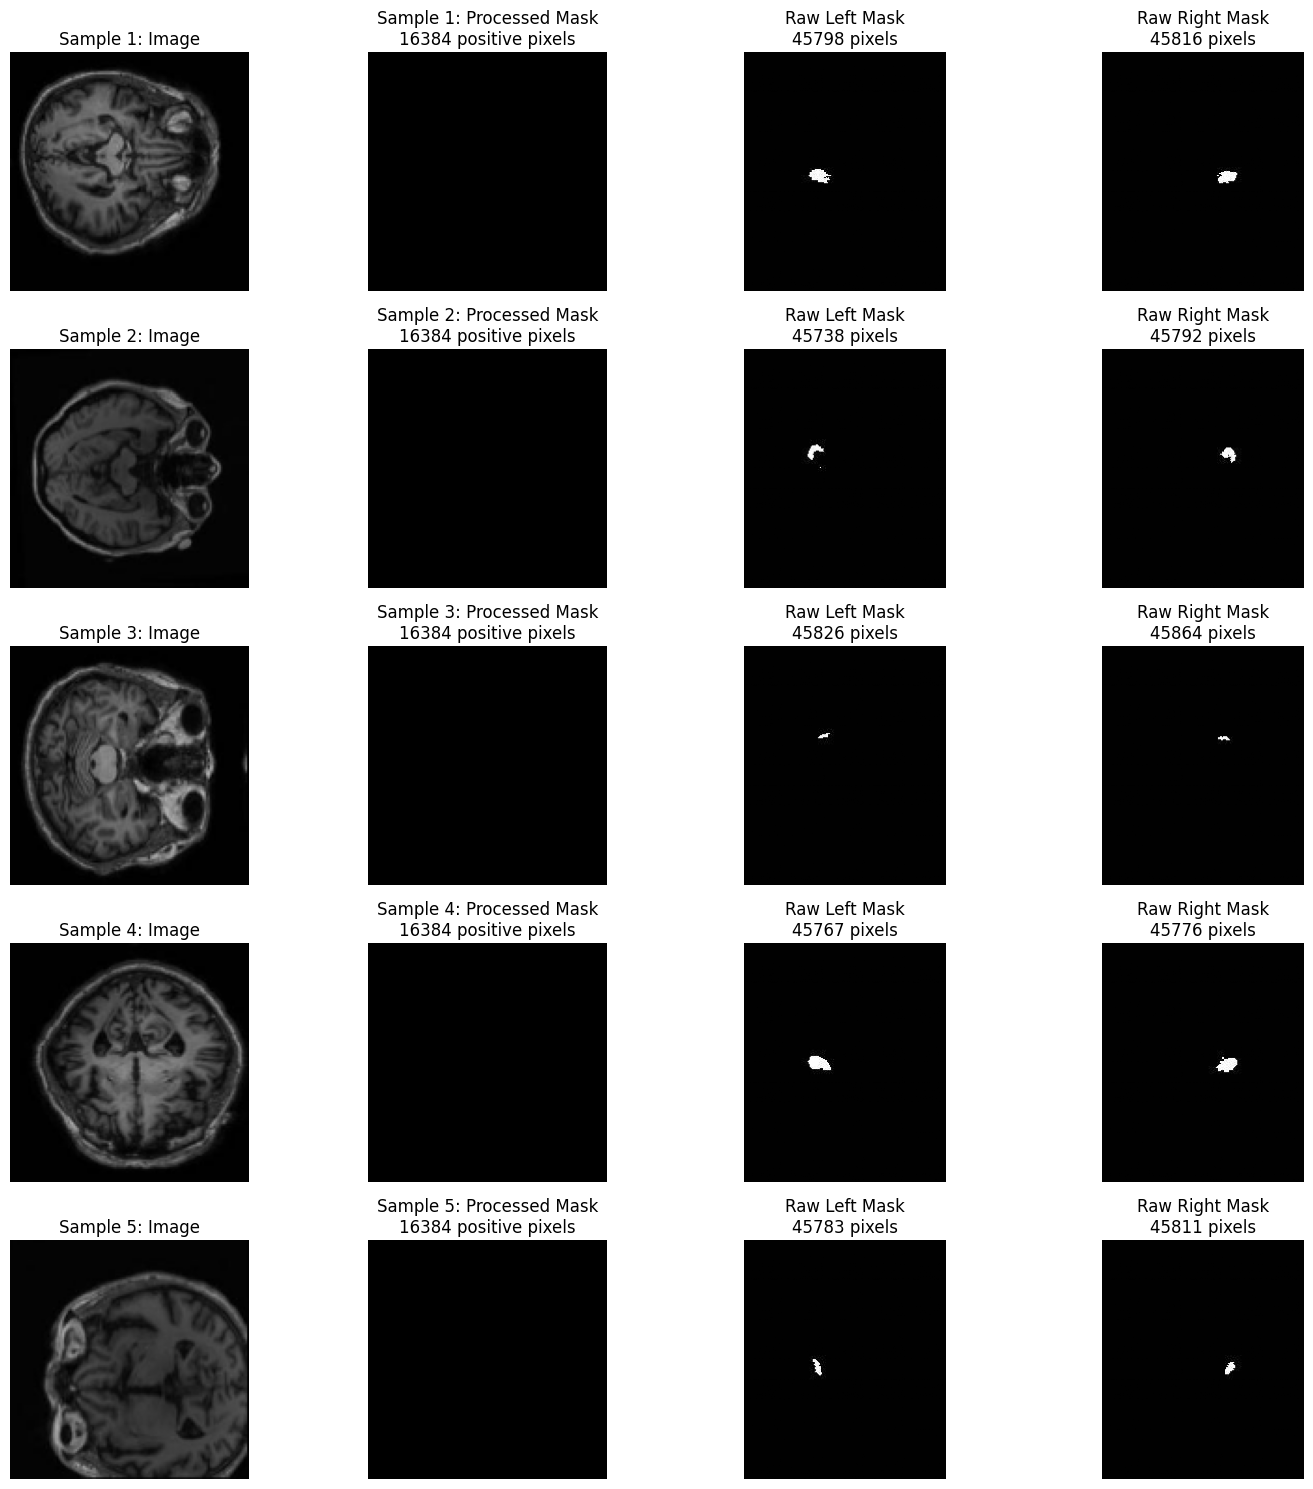

Displayed 5 sample image-mask pairs with raw masks.


In [24]:
# Cell 4: Visualize Dataset Samples
# Purpose: Display image-mask pairs and raw masks to confirm content.
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_samples(X, Y, train_data, num_samples=5):
    if len(X) < num_samples:
        num_samples = len(X)
        print(f"Warning: Only {num_samples} samples available.")

    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        img_path, left_path, right_path = train_data[i]
        # Image
        plt.subplot(num_samples, 4, 4 * i + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Sample {i+1}: Image")
        plt.axis('off')
        # Processed mask
        plt.subplot(num_samples, 4, 4 * i + 2)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title(f"Sample {i+1}: Processed Mask\n{int(np.sum(Y[i]))} positive pixels")
        plt.axis('off')
        # Raw left mask
        plt.subplot(num_samples, 4, 4 * i + 3)
        if left_path:
            raw_left = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
            plt.imshow(raw_left, cmap='gray')
            plt.title(f"Raw Left Mask\n{np.sum(raw_left > 0)} pixels")
        else:
            plt.text(0.5, 0.5, "No Left Mask", ha='center', va='center')
        plt.axis('off')
        # Raw right mask
        plt.subplot(num_samples, 4, 4 * i + 4)
        if right_path:
            raw_right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
            plt.imshow(raw_right, cmap='gray')
            plt.title(f"Raw Right Mask\n{np.sum(raw_right > 0)} pixels")
        else:
            plt.text(0.5, 0.5, "No Right Mask", ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(X_train, Y_train, train_data, num_samples=5)
print("Displayed 5 sample image-mask pairs with raw masks.")

In [25]:
# Cell 3: Data Loading
# Purpose: Load MRI images and masks, combine left/right, debug mask content.
import os
import numpy as np
import cv2
import zipfile
from sklearn.model_selection import train_test_split

def load_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img.astype(np.float32)

def load_mask(mask_left_path, mask_right_path, target_size=(128, 128)):
    mask = np.zeros(target_size, dtype=np.float32)
    debug_info = []

    for path, side in [(mask_left_path, 'left'), (mask_right_path, 'right')]:
        if not path:
            debug_info.append(f"No {side} mask provided")
            continue
        if not os.path.exists(path):
            debug_info.append(f"{side} mask not found: {path}")
            continue
        raw_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if raw_mask is None:
            debug_info.append(f"Failed to load {side} mask: {path}")
            continue
        # Debug raw mask
        debug_info.append(
            f"Raw {side} mask {os.path.basename(path)}: "
            f"shape={raw_mask.shape}, min={raw_mask.min()}, max={raw_mask.max()}, "
            f"sum={raw_mask.sum()}, unique={np.unique(raw_mask)[:10]}"
        )
        # Resize first
        resized_mask = cv2.resize(raw_mask, target_size, interpolation=cv2.INTER_NEAREST)
        # Normalize to [0,1]
        if raw_mask.max() > 0:
            norm_mask = resized_mask / raw_mask.max()
        else:
            norm_mask = resized_mask
        # Threshold to binary
        binary_mask = (norm_mask > 0.1).astype(np.float32)
        pixel_sum = np.sum(binary_mask)
        debug_info.append(f"Threshold >0.1: {pixel_sum} positive pixels")
        debug_info.append(f"Binary mask min={binary_mask.min()}, max={binary_mask.max()}")
        mask = np.maximum(mask, binary_mask)

    pixel_sum = np.sum(mask)
    debug_info.append(f"Combined mask: {pixel_sum} positive pixels")
    if pixel_sum == 0:
        debug_info.append(f"Warning: Combined mask is empty for {os.path.basename(mask_left_path or mask_right_path)}")
    print("\n".join(debug_info))
    return mask[:, :, np.newaxis].astype(np.float32)

# Unzip dataset
zip_path = '/content/hippocampus segmentation dataset.zip'
extract_path = '/content/hippocampus_dataset'
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"Zip file not found: {zip_path}")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Find files
def find_files(directory, extensions):
    files = []
    for root, _, filenames in os.walk(directory):
        for f in filenames:
            if any(f.lower().endswith(ext) for ext in extensions):
                files.append(os.path.join(root, f))
    return sorted(files)

image_extensions = ('.jpg', '.jpeg', '.png')
mask_extensions = ('.jpg', '.jpeg', '.png')
image_files = find_files(os.path.join(extract_path, 'aug/images'), image_extensions)
mask_left_files = find_files(os.path.join(extract_path, 'aug/masks/left'), mask_extensions)
mask_right_files = find_files(os.path.join(extract_path, 'aug/masks/right'), mask_extensions)

print(f"Found {len(image_files)} image files, {len(mask_left_files)} left mask files, {len(mask_right_files)} right mask files")
if image_files:
    print("Sample images:", image_files[:3])
if mask_left_files:
    print("Sample left masks:", mask_left_files[:3])
if mask_right_files:
    print("Sample right masks:", mask_right_files[:3])

# Pair images with masks
train_data = []
for img in image_files:
    img_name = os.path.basename(img).lower().split('.')[0]
    left_mask = next((m for m in mask_left_files if img_name.replace('img', 'maskleft') in m.lower()), None)
    right_mask = next((m for m in mask_right_files if img_name.replace('img', 'maskright') in m.lower()), None)
    if left_mask or right_mask:
        train_data.append((img, left_mask, right_mask))
    else:
        print(f"Warning: No masks found for image: {img}")

print(f"Paired {len(train_data)} image-mask pairs")
if not train_data:
    raise ValueError("No image-mask pairs found. Check file names or directory structure.")

# Load data (full dataset)
X = []
Y = []
for img_path, left_path, right_path in train_data:
    try:
        img = load_image(img_path)
        mask = load_mask(left_path, right_path)
        X.append(img)
        Y.append(mask)
    except Exception as e:
        print(f"Error loading {img_path}: {str(e)}")

X = np.array(X)
Y = np.array(Y)
if X.shape[0] == 0:
    raise ValueError("No data loaded.")

# Split data
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")
print(f"Sample mask positive pixels: {np.sum(Y_train[:5], axis=(1,2,3)).tolist()}")

Found 499 image files, 499 left mask files, 499 right mask files
Sample images: ['/content/hippocampus_dataset/aug/images/img_aug1.jpg', '/content/hippocampus_dataset/aug/images/img_aug10.jpg', '/content/hippocampus_dataset/aug/images/img_aug100.jpg']
Sample left masks: ['/content/hippocampus_dataset/aug/masks/left/maskleft_aug1.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug10.jpg', '/content/hippocampus_dataset/aug/masks/left/maskleft_aug100.jpg']
Sample right masks: ['/content/hippocampus_dataset/aug/masks/right/maskright_aug1.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug10.jpg', '/content/hippocampus_dataset/aug/masks/right/maskright_aug100.jpg']
Paired 499 image-mask pairs
Raw left mask maskleft_aug1.jpg: shape=(233, 197), min=0, max=255, sum=93910, unique=[0 1 2 3 4 5 6 7 8 9]
Threshold >0.1: 70.0 positive pixels
Binary mask min=0.0, max=1.0
Raw right mask maskright_aug1.jpg: shape=(233, 197), min=0, max=255, sum=89102, unique=[0 1 2 3 4 5 6 7 

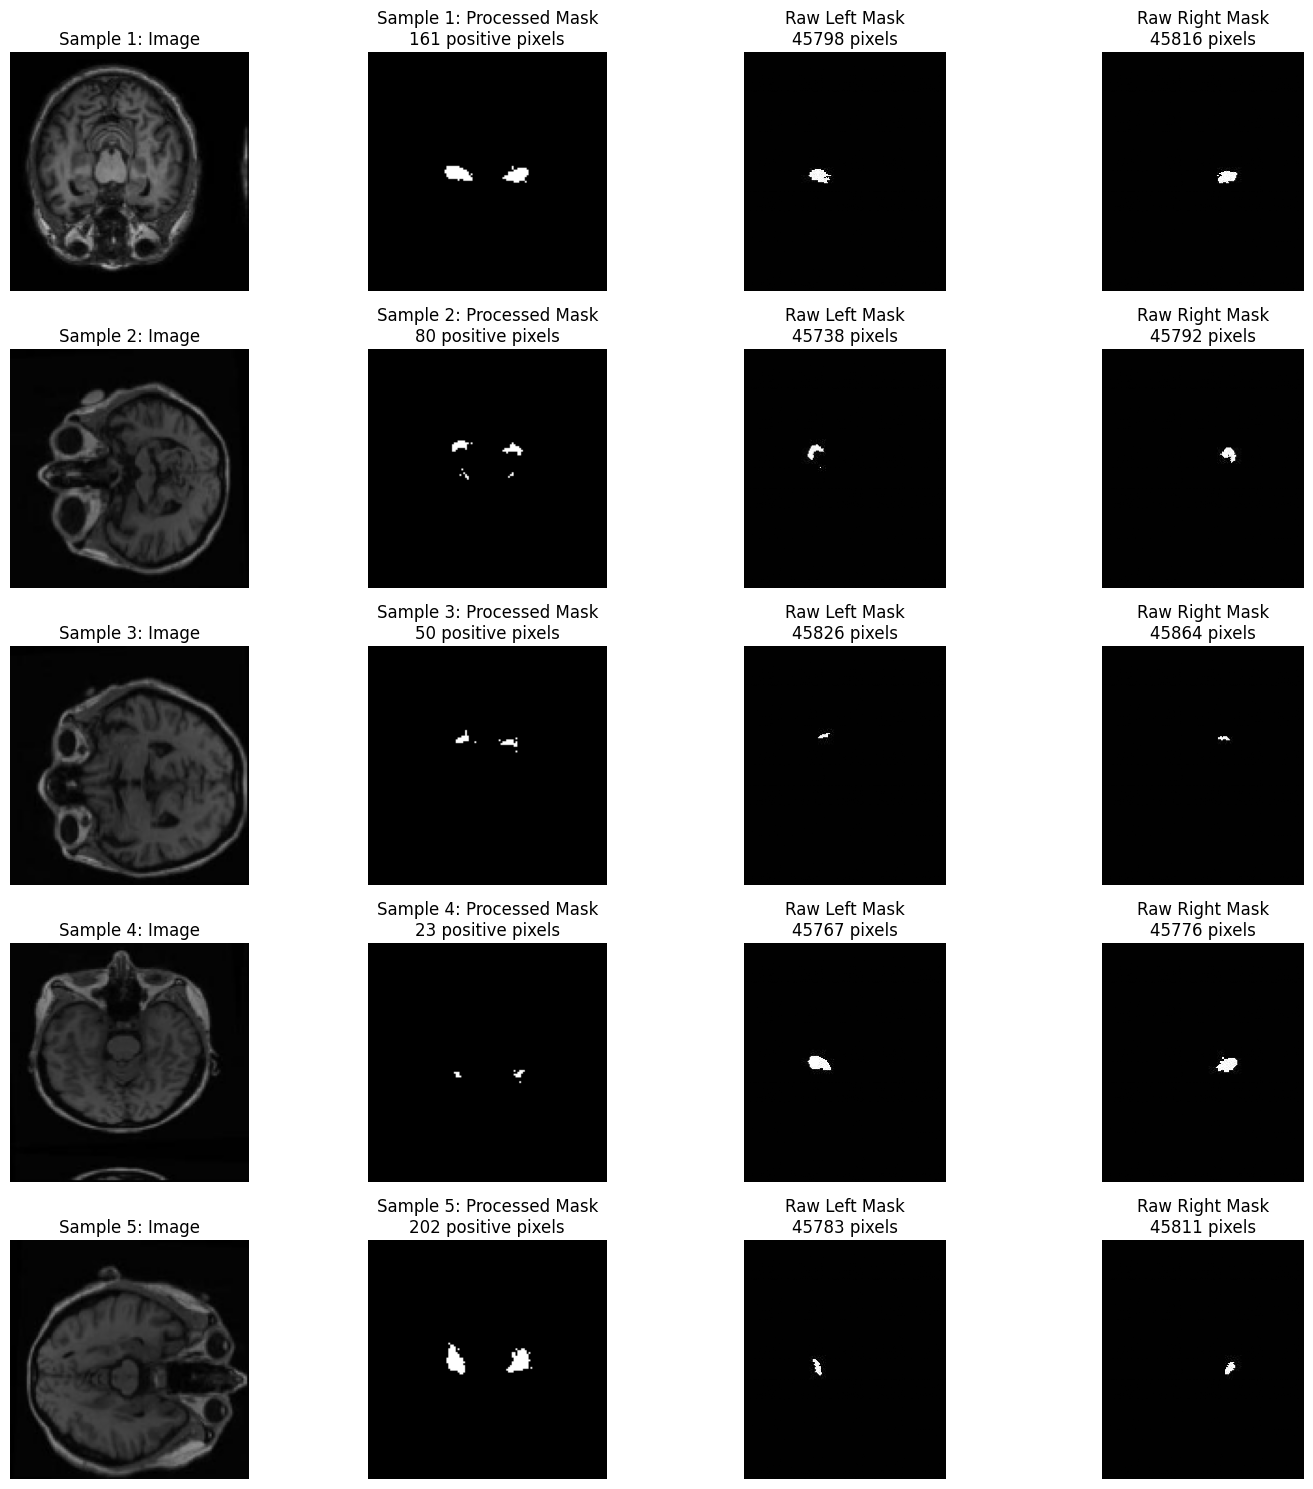

Displayed 5 sample image-mask pairs with raw masks.


In [26]:
# Cell 4: Visualize Dataset Samples
# Purpose: Display image-mask pairs and raw masks with correct scaling.
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_samples(X, Y, train_data, num_samples=5):
    if len(X) < num_samples:
        num_samples = len(X)
        print(f"Warning: Only {num_samples} samples available.")

    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        img_path, left_path, right_path = train_data[i]
        # Image
        plt.subplot(num_samples, 4, 4 * i + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Sample {i+1}: Image")
        plt.axis('off')
        # Processed mask
        plt.subplot(num_samples, 4, 4 * i + 2)
        mask = Y[i].squeeze()
        plt.imshow(mask, cmap='gray', vmin=0, vmax=1)  # Explicit scaling
        plt.title(f"Sample {i+1}: Processed Mask\n{int(np.sum(mask))} positive pixels")
        plt.axis('off')
        # Raw left mask
        plt.subplot(num_samples, 4, 4 * i + 3)
        if left_path:
            raw_left = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
            if raw_left is not None:
                plt.imshow(raw_left, cmap='gray')
                plt.title(f"Raw Left Mask\n{np.sum(raw_left > 0)} pixels")
            else:
                plt.text(0.5, 0.5, "Failed to Load", ha='center', va='center')
        else:
            plt.text(0.5, 0.5, "No Left Mask", ha='center', va='center')
        plt.axis('off')
        # Raw right mask
        plt.subplot(num_samples, 4, 4 * i + 4)
        if right_path:
            raw_right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
            if raw_right is not None:
                plt.imshow(raw_right, cmap='gray')
                plt.title(f"Raw Right Mask\n{np.sum(raw_right > 0)} pixels")
            else:
                plt.text(0.5, 0.5, "Failed to Load", ha='center', va='center')
        else:
            plt.text(0.5, 0.5, "No Right Mask", ha='center', va='center')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(X_train, Y_train, train_data, num_samples=5)
print("Displayed 5 sample image-mask pairs with raw masks.")

In [27]:
# Cell 8: Training
# Purpose: Train ResUNet and U-Net, validate mask content.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def weighted_bce(y_true, y_pred):
    weights = tf.where(y_true > 0, 10.0, 1.0)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    bce = tf.expand_dims(bce, axis=-1)
    weighted_loss = bce * weights
    return tf.reduce_mean(weighted_loss)

# Validate masks
train_mask_pixels = np.sum(Y_train, axis=(1,2,3))
test_mask_pixels = np.sum(Y_test, axis=(1,2,3))
print(f"Training masks: {len(train_mask_pixels)} total, {np.sum(train_mask_pixels > 0)} non-empty")
print(f"Test masks: {len(test_mask_pixels)} total, {np.sum(test_mask_pixels > 0)} non-empty")
if np.all(train_mask_pixels == 0) or np.all(test_mask_pixels == 0):
    raise ValueError("Empty masks detected. Check Cell 3 and Cell 4 outputs.")

data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

batch_size = 8
drive_model_path = '/content/drive/MyDrive/Hippocampus_Models'
os.makedirs(drive_model_path, exist_ok=True)

resunet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'ResUNet.h5'),
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_dice_coef', mode='max')
]
if X_train.shape[0] > 0:
    print("Training ResUNet...")
    resunet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce,
        metrics=[dice_coef, iou]
    )
    resunet_results = resunet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=resunet_callbacks,
        verbose=1
    )

unet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(drive_model_path, 'U-Net.h5'),
        save_best_only=True,
        monitor='val_dice_coef',
        mode='max'
    ),
    keras.callbacks.EarlyStopping(patience=10, monitor='val_dice_coef', mode='max')
]
if X_train.shape[0] > 0:
    print("Training U-Net...")
    unet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce,
        metrics=[dice_coef, iou]
    )
    unet_results = unet_model.fit(
        image_datagen.flow(X_train, Y_train, batch_size=batch_size, seed=seed),
        epochs=50,
        validation_data=(X_test, Y_test),
        callbacks=unet_callbacks,
        verbose=1
    )

print("Training complete. Models saved to Google Drive.")

Training masks: 449 total, 449 non-empty
Test masks: 50 total, 50 non-empty
Training ResUNet...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - dice_coef: 0.0148 - iou: 0.0075 - loss: 5.2564

57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 257ms/step - dice_coef: 0.0149 - iou: 0.0075 - loss: 5.2162 - val_dice_coef: 0.0140 - val_iou: 0.0070 - val_loss: 2.7831
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - dice_coef: 0.0185 - iou: 0.0093 - loss: 0.4919 - val_dice_coef: 0.0132 - val_iou: 0.0066 - val_loss: 2.0531
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - dice_coef: 0.0172 - iou: 0.0087 - loss: 0.3273 - val_dice_coef: 0.0128 - val_iou: 0.0064 - val_loss: 1.3560
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - dice_coef: 0.0195 - iou: 0.0098 - loss: 0.3004 - val_dice_coef: 0.0139 - val_iou: 0.0070 - val_loss: 0.7587
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.0184 - iou: 0.0093 - loss: 0.2741

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - dice_coef: 0.0184 - iou: 0.0093 - loss: 0.2741 - val_dice_coef: 0.0150 - val_iou: 0.0075 - val_loss: 0.5041
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.0204 - iou: 0.0103 - loss: 0.2626

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.0204 - iou: 0.0103 - loss: 0.2626 - val_dice_coef: 0.0164 - val_iou: 0.0083 - val_loss: 0.4310
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.0207 - iou: 0.0104 - loss: 0.2626

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - dice_coef: 0.0206 - iou: 0.0104 - loss: 0.2624 - val_dice_coef: 0.0176 - val_iou: 0.0089 - val_loss: 0.3358
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - dice_coef: 0.0205 - iou: 0.0104 - loss: 0.2486

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - dice_coef: 0.0205 - iou: 0.0104 - loss: 0.2486 - val_dice_coef: 0.0189 - val_iou: 0.0096 - val_loss: 0.3000
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.0210 - iou: 0.0106 - loss: 0.2366

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - dice_coef: 0.0210 - iou: 0.0106 - loss: 0.2366 - val_dice_coef: 0.0206 - val_iou: 0.0104 - val_loss: 0.2680
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - dice_coef: 0.0221 - iou: 0.0112 - loss: 0.2410 - val_dice_coef: 0.0192 - val_iou: 0.0097 - val_loss: 0.2761
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - dice_coef: 0.0215 - iou: 0.0109 - loss: 0.2345

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - dice_coef: 0.0215 - iou: 0.0109 - loss: 0.2344 - val_dice_coef: 0.0227 - val_iou: 0.0115 - val_loss: 0.2453
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - dice_coef: 0.0207 - iou: 0.0105 - loss: 0.2273 - val_dice_coef: 0.0205 - val_iou: 0.0104 - val_loss: 0.2506
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - dice_coef: 0.0207 - iou: 0.0105 - loss: 0.2240 - val_dice_coef: 0.0198 - val_iou: 0.0100 - val_loss: 0.2519
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - dice_coef: 0.0218 - iou: 0.0110 - loss: 0.2247 - val_dice_coef: 0.0222 - val_iou: 0.0112 - val_loss: 0.2383
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.0222 - iou: 0.0112 - loss: 0.2266

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - dice_coef: 0.0222 - iou: 0.0112 - loss: 0.2265 - val_dice_coef: 0.0229 - val_iou: 0.0116 - val_loss: 0.2281
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - dice_coef: 0.0207 - iou: 0.0105 - loss: 0.2186 - val_dice_coef: 0.0205 - val_iou: 0.0104 - val_loss: 0.2456
Epoch 17/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.0232 - iou: 0.0117 - loss: 0.2224

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.0232 - iou: 0.0117 - loss: 0.2224 - val_dice_coef: 0.0245 - val_iou: 0.0124 - val_loss: 0.2223
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - dice_coef: 0.0236 - iou: 0.0120 - loss: 0.2135 - val_dice_coef: 0.0207 - val_iou: 0.0105 - val_loss: 0.2352
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - dice_coef: 0.0233 - iou: 0.0118 - loss: 0.2183 - val_dice_coef: 0.0224 - val_iou: 0.0113 - val_loss: 0.2419
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - dice_coef: 0.0239 - iou: 0.0121 - loss: 0.2185

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - dice_coef: 0.0239 - iou: 0.0121 - loss: 0.2185 - val_dice_coef: 0.0247 - val_iou: 0.0125 - val_loss: 0.2146
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - dice_coef: 0.0249 - iou: 0.0126 - loss: 0.2162

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - dice_coef: 0.0249 - iou: 0.0126 - loss: 0.2162 - val_dice_coef: 0.0273 - val_iou: 0.0139 - val_loss: 0.2073
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - dice_coef: 0.0248 - iou: 0.0126 - loss: 0.2164

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - dice_coef: 0.0248 - iou: 0.0126 - loss: 0.2164 - val_dice_coef: 0.0309 - val_iou: 0.0157 - val_loss: 0.1964
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - dice_coef: 0.0243 - iou: 0.0123 - loss: 0.2155 - val_dice_coef: 0.0229 - val_iou: 0.0116 - val_loss: 0.2264
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - dice_coef: 0.0241 - iou: 0.0122 - loss: 0.2137 - val_dice_coef: 0.0275 - val_iou: 0.0140 - val_loss: 0.2066
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - dice_coef: 0.0234 - iou: 0.0119 - loss: 0.2132 - val_dice_coef: 0.0266 - val_iou: 0.0135 - val_loss: 0.2087
Epoch 26/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - dice_coef: 0.0251 - iou: 0.0127 - loss: 0.2122 - val_dice_coef: 0.0268 - val_iou: 0.0136 - val_loss: 0.2203
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - dice_coef: 0.0261 - iou: 0.0132 - loss: 0.2126 - val_dice_coef: 0.0248 - val_iou: 0.0126 - val_loss: 0.2294
Epoch 28/50
57/57 ━━━━━━━━━━━━━━━━━━━━

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - dice_coef: 0.0145 - iou: 0.0073 - loss: 164.9066 - val_dice_coef: 0.0132 - val_iou: 0.0067 - val_loss: 0.6521
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - dice_coef: 0.0097 - iou: 0.0049 - loss: 0.5620 - val_dice_coef: 0.0081 - val_iou: 0.0041 - val_loss: 0.3045
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coef: 0.0132 - iou: 0.0066 - loss: 0.2843

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - dice_coef: 0.0132 - iou: 0.0067 - loss: 0.2838 - val_dice_coef: 0.0222 - val_iou: 0.0112 - val_loss: 0.2215
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coef: 0.0203 - iou: 0.0102 - loss: 0.2331

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - dice_coef: 0.0203 - iou: 0.0102 - loss: 0.2331 - val_dice_coef: 0.0245 - val_iou: 0.0124 - val_loss: 0.2117
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coef: 0.0215 - iou: 0.0109 - loss: 0.2201

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - dice_coef: 0.0215 - iou: 0.0109 - loss: 0.2202 - val_dice_coef: 0.0254 - val_iou: 0.0129 - val_loss: 0.2093
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - dice_coef: 0.0247 - iou: 0.0125 - loss: 0.2171 - val_dice_coef: 0.0245 - val_iou: 0.0124 - val_loss: 0.2132
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - dice_coef: 0.0251 - iou: 0.0127 - loss: 0.2191 - val_dice_coef: 0.0251 - val_iou: 0.0127 - val_loss: 0.2097
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - dice_coef: 0.0263 - iou: 0.0133 - loss: 0.2095 - val_dice_coef: 0.0242 - val_iou: 0.0123 - val_loss: 0.2120
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - dice_coef: 0.0245 - iou: 0.0124 - loss: 0.2094 - val_dice_coef: 0.0244 - val_iou: 0.0124 - val_loss: 0.2106
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - dice_coef: 0.0262 - iou: 0.0133 - loss: 0.2097

57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - dice_coef: 0.0262 - iou: 0.0133 - loss: 0.2098 - val_dice_coef: 0.0256 - val_iou: 0.0130 - val_loss: 0.2059
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - dice_coef: 0.0269 - iou: 0.0137 - loss: 0.2128 - val_dice_coef: 0.0242 - val_iou: 0.0122 - val_loss: 0.2255
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - dice_coef: 0.0258 - iou: 0.0131 - loss: 0.2070 - val_dice_coef: 0.0255 - val_iou: 0.0129 - val_loss: 0.2131
Epoch 13/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - dice_coef: 0.0228 - iou: 0.0115 - loss: 0.2053 - val_dice_coef: 0.0242 - val_iou: 0.0123 - val_loss: 0.2118
Epoch 14/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - dice_coef: 0.0263 - iou: 0.0134 - loss: 0.2094 - val_dice_coef: 0.0239 - val_iou: 0.0121 - val_loss: 0.2142
Epoch 15/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - dice_coef: 0.0259 - iou: 0.0131 - loss: 0.2043 - val_dice_coef: 0.0246 - val_iou: 0.0125 - val_loss: 0.2079
Epoch 16/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - dice_coef: 0.0271 - iou: 0.0137 - loss: 0.2039 - val_dice_coef: 0.0264 - val_iou: 0.0134 - val_loss: 0.2080
Epoch 18/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - dice_coef: 0.0269 - iou: 0.0136 - loss: 0.2059 - val_dice_coef: 0.0259 - val_iou: 0.0131 - val_loss: 0.2042
Epoch 19/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - dice_coef: 0.0286 - iou: 0.0145 - loss: 0.2106 - val_dice_coef: 0.0251 - val_iou: 0.0127 - val_loss: 0.2139
Epoch 20/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - dice_coef: 0.0277 - iou: 0.0141 - loss: 0.1996 - val_dice_coef: 0.0254 - val_iou: 0.0129 - val_loss: 0.2114
Epoch 21/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - dice_coef: 0.0274 - iou: 0.0139 - loss: 0.1980 - val_dice_coef: 0.0253 - val_iou: 0.0128 - val_loss: 0.2173
Epoch 22/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - dice_coef: 0.0257 - iou: 0.0130 - loss: 0.2031

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - dice_coef: 0.0257 - iou: 0.0131 - loss: 0.2032 - val_dice_coef: 0.0276 - val_iou: 0.0140 - val_loss: 0.2019
Epoch 23/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - dice_coef: 0.0285 - iou: 0.0145 - loss: 0.2045 - val_dice_coef: 0.0270 - val_iou: 0.0137 - val_loss: 0.2035
Epoch 24/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - dice_coef: 0.0285 - iou: 0.0144 - loss: 0.2046 - val_dice_coef: 0.0266 - val_iou: 0.0135 - val_loss: 0.2066
Epoch 25/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - dice_coef: 0.0274 - iou: 0.0139 - loss: 0.2139 - val_dice_coef: 0.0253 - val_iou: 0.0128 - val_loss: 0.2135
Epoch 26/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - dice_coef: 0.0288 - iou: 0.0146 - loss: 0.2027 - val_dice_coef: 0.0268 - val_iou: 0.0136 - val_loss: 0.2040
Epoch 27/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - dice_coef: 0.0310 - iou: 0.0157 - loss: 0.2025 - val_dice_coef: 0.0265 - val_iou: 0.0134 - val_loss: 0.2080
Epoch 28/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 4